# HiddenLayer Graph Demo - PyTorch

In [1]:
import torch
import torchvision.models
import hiddenlayer as hl

## VGG16

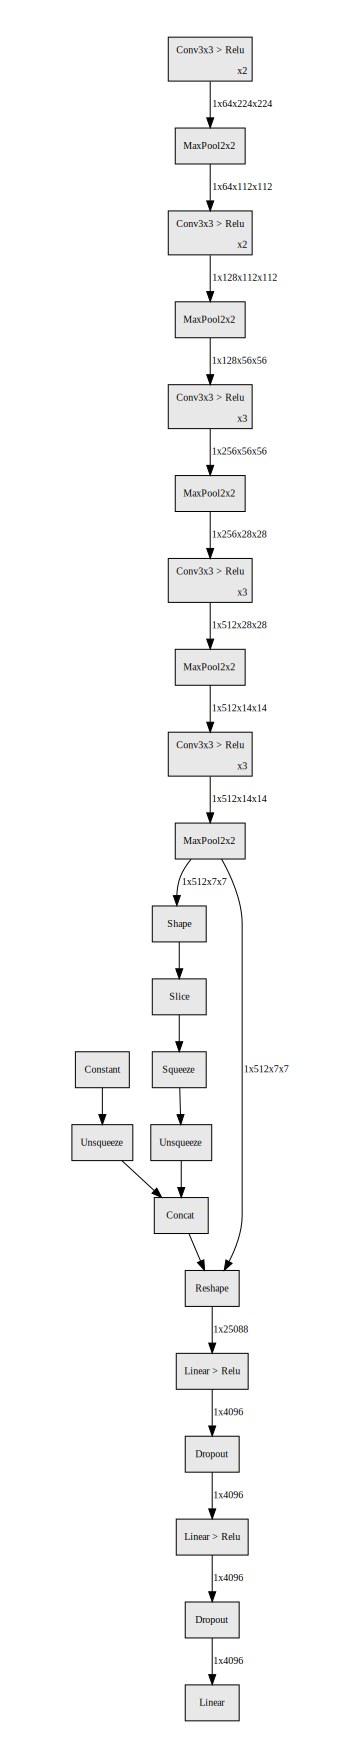

In [2]:
# VGG16 with BatchNorm
model = torchvision.models.vgg16()

# Build HiddenLayer graph
# Jupyter Notebook renders it automatically
hl.build_graph(model, torch.zeros([1, 3, 224, 224]))

## AlexNet

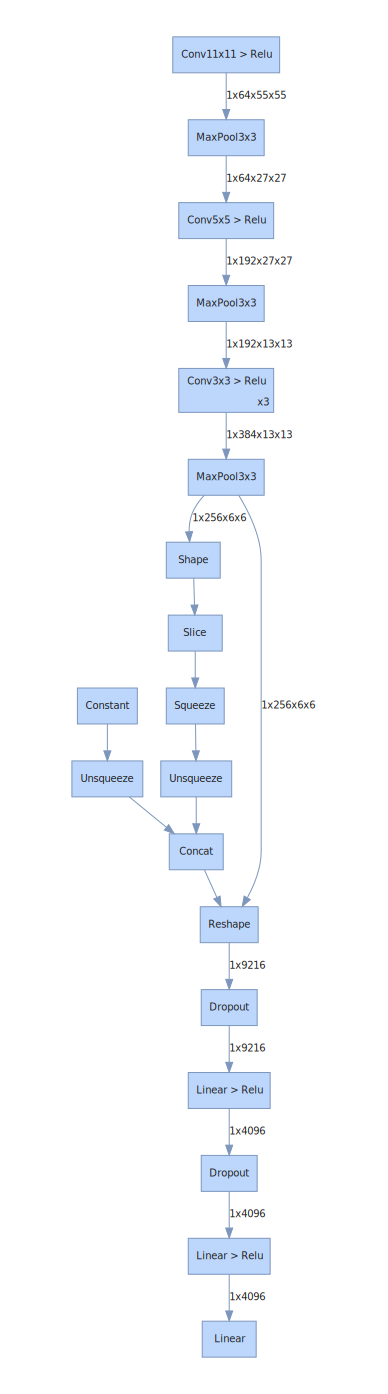

In [3]:
# AlexNet
model = torchvision.models.alexnet()

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([1, 3, 224, 224]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

## Transforms and Graph Expressions

A Graph Expression is like a Regular Expression for graphs. It simplifies searching for nodes that fit a particular pattern. For example, the graph expression `Conv > Relu` will find Conv layers that are followed by RELU layers. And the expressions `Conv | MaxPool` will match any Conv and MaxPool layers that are in parallel branches (i.e. have the same parent node). See examples of more complex graph expressions below.

Once the graph expression finds the nodes, we use Transforms to modify them. For example, if we want to delete all nodes of type `Const`, we'll use the transform `Prune("Const")`. The graph expression here is simple, `Const`, which matches any node with operation of type Const. And the Prune() transform deletes the node.

See more examples below. And, also, check `SIMPLICITY_TRANSFORMS` in `transforms.py`.

## ResNet101

ResNet101 is a large network, but it consists of repetitive patterns. To simplify drawing the graph, we define our own transforms that find Residual Blocks and folds them together. 

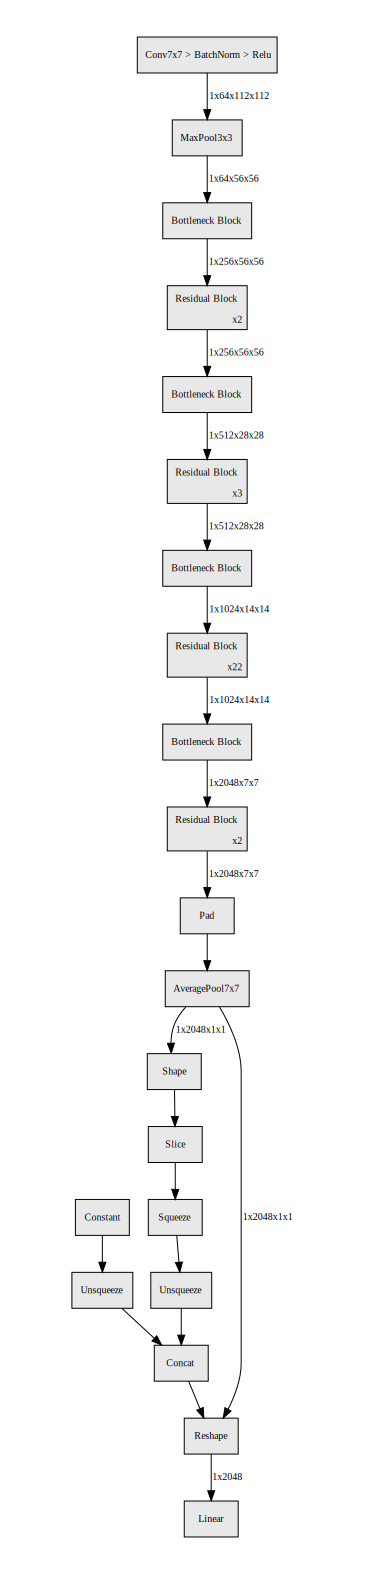

In [4]:
# Resnet101
model = torchvision.models.resnet101()

# Rather than using the default transforms, build custom ones to group
# nodes of residual and bottleneck blocks.
transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]

# Display graph using the transforms above
hl.build_graph(model, torch.zeros([1, 3, 224, 224]), transforms=transforms)

Comment out one of these lines if you want to see the original graph before transforms are applied.

In [5]:
# Without simplification transforms, but include framework transforms
# Framework transforms map PyTorch or TensorFlow graphs into a standard format
# based, mostly, on ONNX naming conventions.

# hl.build_graph(model, torch.zeros([1, 3, 224, 224]), transforms=[])

In [6]:
# Remove all transforms completely
# Override both, simplicity transforms and framework transforms, to get
# the original raw graph.

# hl.build_graph(model, torch.zeros([1, 3, 224, 224]), transforms=[], framework_transforms=[])